In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/test_colab/ml_project2/src

/content/gdrive/My Drive/test_colab/ml_project2/src


In [3]:
! git pull

Already up to date.


In [4]:
!ls ../data

test  train


In [5]:
import sound_processing as sp

In [6]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import glob

In [7]:
#sample_rate, samples = wavfile.read('../data/Pn_GVA_Cases/Pn_GVA_Ca10/audio/Pn_GVA_Ca10_P1.wav')
#sp.show_spec_from_sample(samples , sample_rate)

100%|██████████| 532/532 [10:26<00:00,  1.18s/it]


[[ 0.00766028  0.00840258  0.00873331 ... -0.00172121 -0.00160556
  -0.00148958]
 [ 0.01916664  0.01933206  0.01948978 ...  0.00051267  0.00034104
   0.0001843 ]] Pn P6 Ca 22050 29


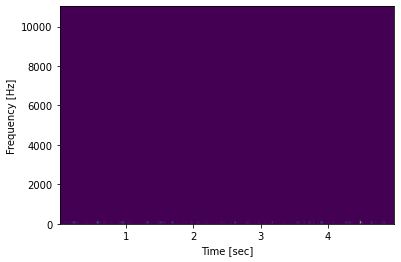

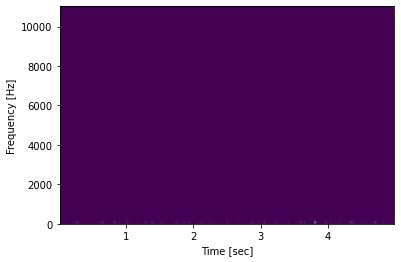

In [8]:
features, diseases, positions, controls, frequences, patientnbs = sp.get_feature_and_labels( '../data/train/*/*/*/'  ) # both control and case

indx = 100 # example on sample nb100

print(features[indx] ,diseases[indx] , positions[indx] , controls[indx] , frequences[indx] , patientnbs[indx])

for sample in features[indx]:
    sp.show_spec_from_sample(sample , frequences[indx])

100%|██████████| 70/70 [01:46<00:00,  1.53s/it]


[[ 5.9706962e-04  6.7813793e-04  7.3362316e-04 ...  1.4544959e-03
   1.4135670e-03  1.3664027e-03]
 [ 4.5743445e-03  4.5443438e-03  4.5135305e-03 ...  6.3816099e-03
   6.5101506e-03  6.6417879e-03]
 [ 1.0954206e-02  1.1060468e-02  1.1153707e-02 ... -2.0139068e-04
  -1.3030520e-04 -6.7431603e-05]
 [-1.6394678e-03 -1.6848879e-03 -1.7421885e-03 ... -2.8045769e-03
  -2.7617300e-03 -2.7151031e-03]] Pn P3 Ca 22050 30


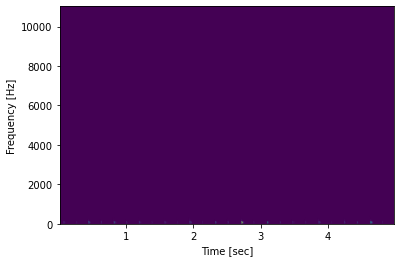

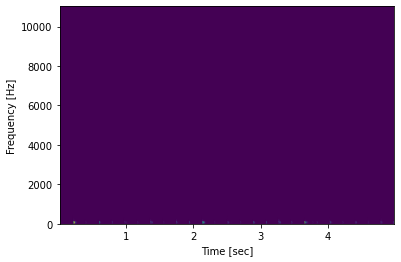

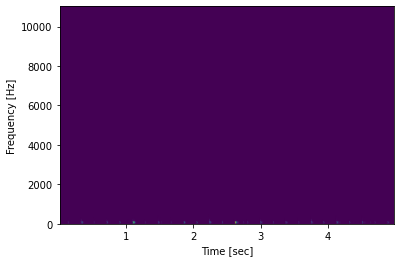

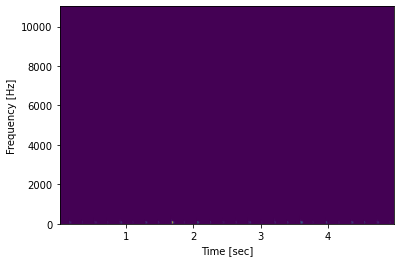

In [9]:
featuresT, diseasesT, positionsT, controlsT, frequencesT, patientnbsT = sp.get_feature_and_labels( '../data/test/*/*/*/'  ) # both control and case

indx = 2 # example on sample nb100

print(featuresT[indx] ,diseasesT[indx] , positionsT[indx] , controlsT[indx] , frequencesT[indx] , patientnbsT[indx])

for sample in featuresT[indx]:
    sp.show_spec_from_sample(sample , frequencesT[indx])

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten, MaxPooling2D, ZeroPadding2D, Dropout, BatchNormalization, Activation
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, CSVLogger, RemoteMonitor, TensorBoard, ReduceLROnPlateau
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

In [55]:
position = 'P8'

indx = positions == position

y_train = (controls[indx] == 'Ca')
x_train = features[indx]

y_train_big = []
x_train_big = []

for i, j in zip(x_train, y_train):
  for subsample in i:
    y_train_big.append(j )
    x_train_big.append(subsample )

y_train = np.array(y_train_big)
x_train = np.array(x_train_big)

print(y_train.shape ,x_train.shape )

(815,) (815, 110250)


In [56]:
indx = positionsT == position

y_test = (controlsT[indx] == 'Ca')
x_test = featuresT[indx]

y_test_big = []
x_test_big = []

for i, j in zip(x_test, y_test):
  for subsample in i:
    y_test_big.append(j )
    x_test_big.append(subsample )

y_test = np.array(y_test_big)
x_test = np.array(x_test_big)

print(y_test.shape ,x_test.shape )
print(y_train.shape)
print(y_train.sum())

(153,) (153, 110250)
(815,)
452


In [57]:
x_train_final = []
x_test_final = []

for sample in x_train:
  x_train_final.append(sp.features_extraction(sample,22050,'stft'))

for sample in x_test:
  x_test_final.append(sp.features_extraction(sample,22050,'stft'))  

x_train_final = np.array(x_train_final)[:,:,:,np.newaxis]
x_test_final = np.array(x_test_final)[:,:,:,np.newaxis]

print(x_train_final.shape,x_test_final.shape)
print(y_train.shape)


(815, 150, 216, 1) (153, 150, 216, 1)
(815,)


In [58]:
#copy

XTr = x_train_final.copy()
XTe = x_test_final.copy()
YTr = y_train.astype(int).copy()
YTe = y_test.astype(int).copy()

print(XTe.shape,XTr.shape)
print(YTe.shape,YTr.shape)


(153, 150, 216, 1) (815, 150, 216, 1)
(153,) (815,)


In [59]:
y_train = to_categorical(YTr)
y_test = to_categorical(YTe)

print(y_train,y_train.shape)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]] (815, 2)


In [60]:
shuffle_indices = np.random.permutation(np.arange(y_train.shape[0]))
y_train = y_train[shuffle_indices]  # rearranges the y_train based on the shuffled indices
XTr = XTr[shuffle_indices]  # rearranges the x_train based on the shuffled indices

In [61]:
print(y_train)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [62]:
shape = XTr.shape[1:]
train_batch_size = 32
train_steps = XTr.shape[0]//train_batch_size # need to specify the number of steps since the data generator outputs continuously


x_test = XTe.astype('float32') # not sure why I do this but let's keep it for now
x_train = XTr.astype('float32')

train_generator = ImageDataGenerator(width_shift_range=20,
                            #height_shift_range=4,
                            #zoom_range=[1/1.3, 1.3],
                            
                            )


train_generator.fit(x_train) #apply the augmetnation to train data

train_datagen = train_generator.flow(x_train, y_train, batch_size=train_batch_size) # creates the mii batch flow



In [63]:
model = Sequential()

model.add(Convolution2D(20, (3, 3), activation='relu', padding='same', input_shape=shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Convolution2D(50, (3, 3), activation='relu', padding='same', input_shape=shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

sgd = optimizers.SGD(lr=0.00004, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])


#Callbacks

checkpointer = ModelCheckpoint(monitor='val_loss', # automatically saves the model 
                               mode='auto', 
                               filepath='../test_model.h5',
                               verbose=1,
                               save_best_only=True,
                               save_freq = 2
                              )

#csv_logger = CSVLogger('/test_model.txt') # saves the output log in csv


#lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, # can be used to reduce the learning rate once the model stops learning
                       #min_delta=0.001, cooldown=1,
                       #verbose=1, patience=10,
                       # min_lr=4.0e-5)

#FitTheModel

history = model.fit_generator(train_datagen,
                              steps_per_epoch=train_steps,
                              epochs=15,
                              validation_data=(x_test, y_test),
                              #callbacks=[checkpointer, verbose=True, csv_logger,
                              #TensorBoardColabCallback(tbc)]
                              )
                              
                              

Epoch 1/15
25/25 [==============================] - 2s 77ms/step - loss: 0.9590 - accuracy: 0.6360 - val_loss: 2.0351 - val_accuracy: 0.2745
Epoch 2/15
25/25 [==============================] - 2s 71ms/step - loss: 0.7131 - accuracy: 0.6999 - val_loss: 0.7088 - val_accuracy: 0.5686
Epoch 3/15
25/25 [==============================] - 2s 70ms/step - loss: 0.6359 - accuracy: 0.7471 - val_loss: 0.3266 - val_accuracy: 0.9085
Epoch 4/15
25/25 [==============================] - 2s 72ms/step - loss: 0.6224 - accuracy: 0.7407 - val_loss: 0.3168 - val_accuracy: 0.9216
Epoch 5/15
25/25 [==============================] - 2s 72ms/step - loss: 0.5521 - accuracy: 0.7739 - val_loss: 0.2436 - val_accuracy: 0.9216
Epoch 6/15
25/25 [==============================] - 2s 72ms/step - loss: 0.5770 - accuracy: 0.7535 - val_loss: 0.1964 - val_accuracy: 0.9412
Epoch 7/15
25/25 [==============================] - 2s 72ms/step - loss: 0.5151 - accuracy: 0.7701 - val_loss: 0.2038 - val_accuracy: 0.8758
Epoch 8/15
25